# Test set Predictions, Results, and Evaluations

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transform
from torch.utils.data import random_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import skorch
import time
import scikitplot as skplt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix as confusion

### loading the test data and demonstrating the properties of the data (will take a few minutes)

In [21]:
transformer = transform.Compose([transform.ToTensor(),
                                  transform.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

test_set = torchvision.datasets.CIFAR10(root='normalized_data/', train=False, download = True, transform=transformer)

In [22]:
print(len(test_set))
print(test_set.classes)

10000
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  cat,  ship,  ship, airplane,  frog,  frog


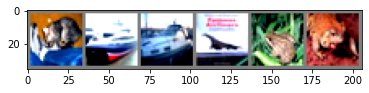

In [23]:
# https://github.com/sanghoon/pytorch_imagenet/blob/master/toy_cifar.py

test_loader = torch.utils.data.DataLoader(test_set, batch_size = 6, shuffle = False, num_workers=4, pin_memory=True)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
    
dataiter = iter(test_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(', '.join('%5s' % test_set.classes[labels[j]] for j in range(6)))

### Loading the two best models: one for Multi-layer Perceptron (MLP), one for convolutional neural network (CNN)

https://skorch.readthedocs.io/en/stable/user/save_load.html <--- how to load and execute the models that have been saved above.

In [24]:
# MLP hyperparameters

mlp_lr = 0.0001
mlp_dropout = 0.2
mlp_nodes1 = 1500
mlp_nodes2 = 500

In [25]:
# defining the MLP

class mlp(nn.Module):
    def __init__(self,
                 dropout = mlp_dropout,
                 nodes1 = mlp_nodes1,     # <--- hyperparameters
                 nodes2 = mlp_nodes2    
                ): 
        super(mlp, self).__init__()
        self.network = nn.Sequential(
        
        nn.Linear(32 * 32 *3, nodes1),  # 3072 = 32 * 32 * 3 (the dimensions of the input images)
        nn.ReLU(inplace = True),
        nn.Dropout(dropout),
        nn.Linear(nodes1, nodes2),
        nn.ReLU(inplace = True),
        nn.Dropout(dropout),
        nn.Linear(nodes2, 10)) # 10 output classes
        
    def forward(self, i):
        return self.network(i)    

In [26]:
from skorch import NeuralNetClassifier

# defining callbacks to be input in to the MLP skorch classifier

earlystopping = skorch.callbacks.EarlyStopping(monitor = 'valid_acc', lower_is_better = False,
                                               patience = 10, threshold_mode = 'abs')

checkpoint = skorch.callbacks.Checkpoint(monitor = 'valid_acc_best')

# defining the MLP classifier object


mlp_net = NeuralNetClassifier(
        mlp,
        criterion = nn.CrossEntropyLoss, 
        max_epochs = 200,
        lr = mlp_lr,
        callbacks = [earlystopping, checkpoint]
        )

# initializing the MLP classifier object, in to which the saved parameters will be loaded
mlp_net.initialize()

# loading the saved parameters
mlp_net.load_params(f_params='mlp_mdl.pkl', f_optimizer='mlp_opt.pkl', f_history='mlp_history.json')

print(mlp_net)

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=mlp(
    (network): Sequential(
      (0): Linear(in_features=3072, out_features=1500, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=1500, out_features=500, bias=True)
      (4): ReLU(inplace=True)
      (5): Dropout(p=0.2, inplace=False)
      (6): Linear(in_features=500, out_features=10, bias=True)
    )
  ),
)


In [27]:
# CNN hyperparameters

cnn_lr = 0.0001
dropout = 0.2

conv1 = 32
conv2 = 64
conv3 = 128
conv4 = 256
conv5 = 512
conv6 = 1024

dense1 = 1000
dense2 = 500

padding1 = 1
stride1 = 1

padding2 = 0
stride2 = 2

In [28]:
# convolutional neural network (CNN): base archictecture, which was the experimented with - taken from:
# https://medium.com/swlh/image-classification-with-cnn-4f2a501faadb

class cnn(nn.Module):
    def __init__(self, 
                dropout = dropout,
                conv1 = conv1, 
                conv2 = conv2,
                conv3 = conv3,
                dense1 = dense1,
                dense2 = dense2,
                stride1 = stride1,
                padding1 = padding1,
                stride2 = stride2,
                padding2 = padding2):
        super(cnn, self).__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, conv1, kernel_size=3, padding=padding1),
            nn.BatchNorm2d(conv1),
            nn.ReLU(inplace = True),
            nn.Conv2d(conv1, conv2, kernel_size=3, stride=stride1, padding=padding1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16: 

            nn.Conv2d(conv2, conv3, kernel_size=3, stride=stride1, padding=padding1),
            nn.ReLU(inplace = True),
            nn.Conv2d(conv3, conv4, kernel_size=3, stride=stride1, padding=padding1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, 2), # output: 256 x 8 x 8

            nn.Conv2d(conv4, conv5, kernel_size=3, stride=stride1, padding=padding1),
            nn.ReLU(inplace = True),
            nn.Conv2d(conv5, conv6, kernel_size=3, stride=stride1, padding=padding1),
            nn.BatchNorm2d(conv6),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, 2), # output: 512 x 4 x 4

            nn.Flatten(), 
            nn.Linear(conv6*4*4, 1000), 
            nn.ReLU(inplace = True),
            nn.Dropout(dropout),
            nn.Linear(1000, 500),
            nn.ReLU(inplace = True),
            nn.Linear(500, 10))
        
    def forward(self, i):
        return self.network(i)

In [29]:
# defining callbacks to be input in to the skorch classifier

from skorch import NeuralNetClassifier

earlystopping = skorch.callbacks.EarlyStopping(monitor = 'valid_acc', lower_is_better = False,
                                               patience = 5, threshold_mode = 'abs')

checkpoint = skorch.callbacks.Checkpoint(monitor = 'valid_acc_best')


# defining the classifier object


cnn_net = NeuralNetClassifier(
        cnn,
        criterion = nn.CrossEntropyLoss,
        optimizer = torch.optim.Adam,
        batch_size = 32,
        max_epochs = 25,
        lr = cnn_lr,
        train_split = skorch.dataset.CVSplit(3),
        callbacks = [earlystopping, checkpoint]
        )

In [30]:
# initializing the CNN, in to which the saved parameters will be loaded
cnn_net.initialize()

# loading the saved parameters
cnn_net.load_params(f_params='cnn_mdl.pkl', f_optimizer='cnn_opt.pkl', f_history='cnn_history.json')

print(cnn_net)

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=cnn(
    (network): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): ReLU(inplace=True)
      (13): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14)

## Making the test set predictions

In [31]:
# preparing the data for skorch/sklearn

xTest = test_set.data

xTest = np.reshape(xTest,(10000,3072))
xTest = xTest.astype('float32')

yTest = np.array([y for x, y in iter(test_set)])

__For reference with the following visuals, the corresponding name labels to each of the integer class labels are as follows:__

> 0. Airplane
> 1. Automobile
> 2. Bird
> 3. Cat
> 4. Deer
> 5. Dog
> 6. Frog
> 7. Horse
> 8. Ship
> 9. Truck

In [32]:
# MLP predictions

mlp_yPreds = mlp_net.predict(xTest)

# creating classification report
mlp_performance = classification_report(yTest, mlp_yPreds)

# creating confusion matrix to plot
mlp_cm = confusion(yTest, mlp_yPreds)

### MLP performance

              precision    recall  f1-score   support

           0       0.61      0.60      0.61      1000
           1       0.63      0.65      0.64      1000
           2       0.45      0.38      0.41      1000
           3       0.36      0.40      0.38      1000
           4       0.50      0.39      0.44      1000
           5       0.41      0.41      0.41      1000
           6       0.62      0.51      0.56      1000
           7       0.53      0.68      0.59      1000
           8       0.68      0.66      0.67      1000
           9       0.55      0.61      0.58      1000

    accuracy                           0.53     10000
   macro avg       0.53      0.53      0.53     10000
weighted avg       0.53      0.53      0.53     10000



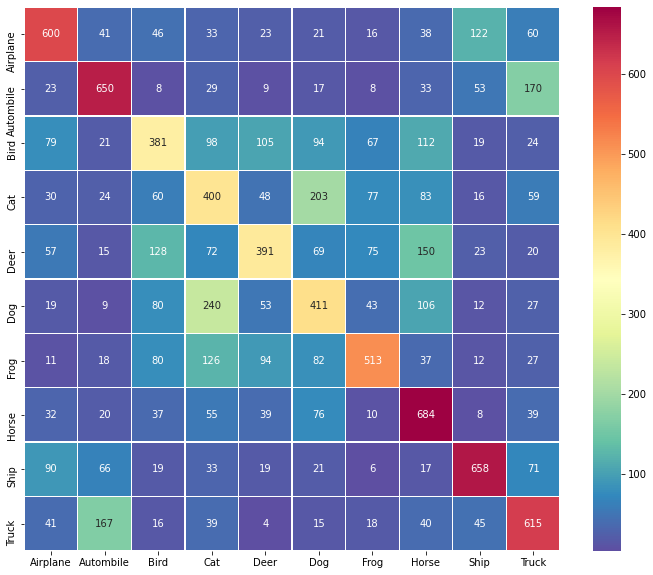

In [39]:
print(mlp_performance)

# creating custom cmap
spectral = plt.get_cmap('Spectral')
spectral = spectral.reversed()

# list of real class names to assign to confusion matrix
labels = ['Airplane','Autombile','Bird', 'Cat', 'Deer',
'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

labels2 = {0: 'Airplane',1: 'Autombile',2: 'Bird', 3: 'Cat', 4: 'Deer',
4: 'Dog', 6: 'Frog', 7: 'Horse', 8: 'Ship', 9: 'Truck'}

fig, ax = plt.subplots(figsize=(12,10)) 
ax = sns.heatmap(mlp_cm, annot = True, fmt = 'g', linewidths = .3, cmap = spectral)
ax.set_xticklabels(labels)
ax.set_yticklabels(labels);

*YTrue on the y axis (there are exactly 1000 instances of each class going along each row), ypreds on the x axis.

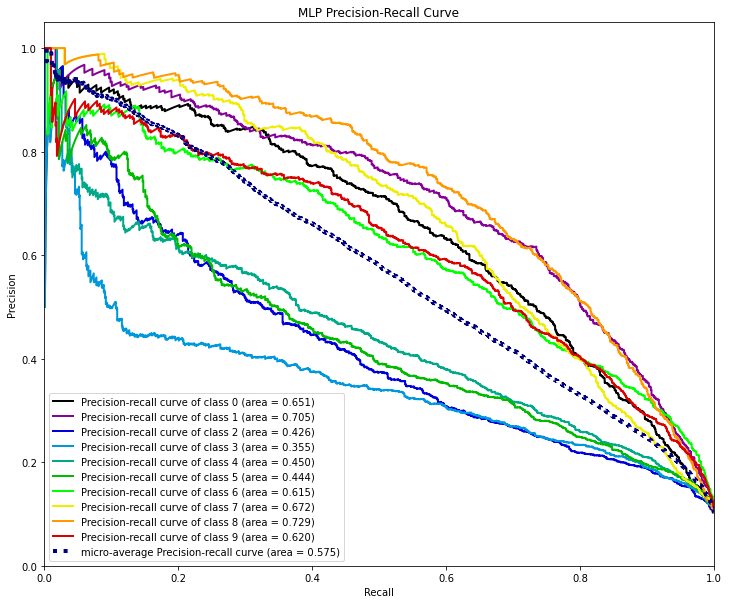

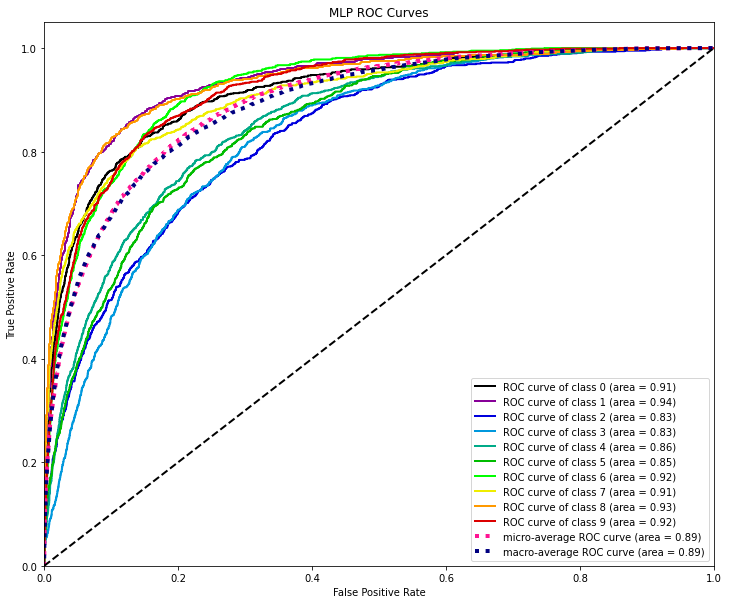

In [41]:
mlp_y_probas = mlp_net.predict_proba(xTest)

skplt.metrics.plot_precision_recall(yTest, mlp_y_probas, figsize = (12, 10), title = 'MLP Precision-Recall Curve');
skplt.metrics.plot_roc(yTest, mlp_y_probas, figsize = (12, 10), title = 'MLP ROC Curves');

As can be seen above, the MLP performed with 53% classification accuracy, very similar to the cross-validation accuracy achieved during the training stage. This accuracy rate generalises well most likely due to the perfectly balanced data sets, both for training and testing, meaning no classification bias can be learnt by the neural network towards majority classes, no matter how many epochs are trained. 

### CNN test set predictions (may take a few minutes)

In [35]:
# preparing data for CNN skorch object
import skorch.helper

xTest2 = skorch.helper.SliceDataset(test_set, idx = 0)

cnn_yPreds = cnn_net.predict(xTest2)
cnn_y_probas = cnn_net.predict_proba(xTest2)

# creating classification report
cnn_performance = classification_report(yTest, cnn_yPreds)

# creating confusion matrix to plot
cnn_cm = confusion(yTest, cnn_yPreds)

### CNN performance

              precision    recall  f1-score   support

           0       0.77      0.87      0.82      1000
           1       0.87      0.92      0.89      1000
           2       0.78      0.68      0.72      1000
           3       0.63      0.68      0.65      1000
           4       0.76      0.76      0.76      1000
           5       0.71      0.74      0.72      1000
           6       0.83      0.85      0.84      1000
           7       0.85      0.84      0.85      1000
           8       0.94      0.81      0.87      1000
           9       0.89      0.84      0.87      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



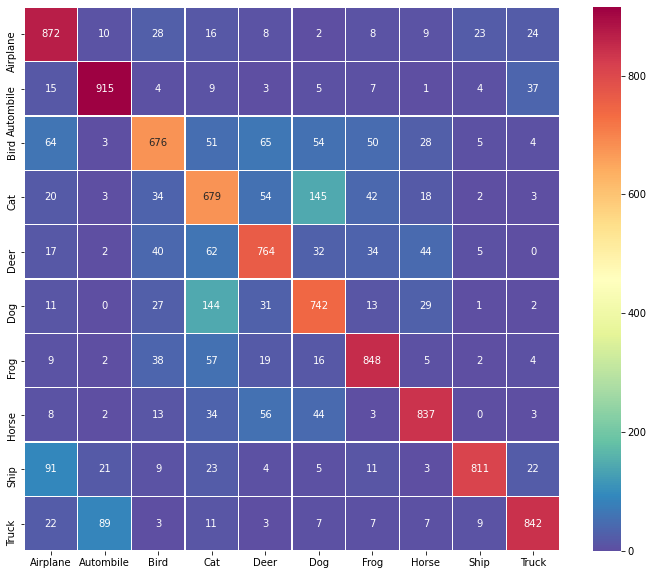

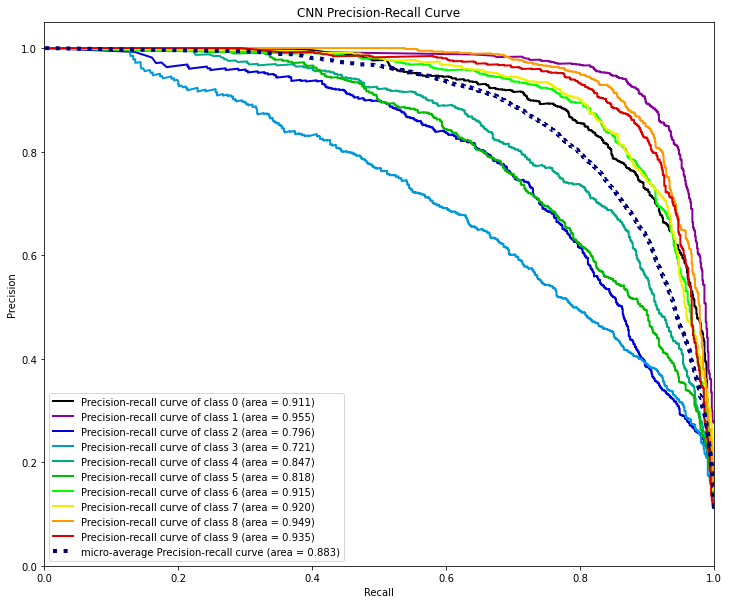

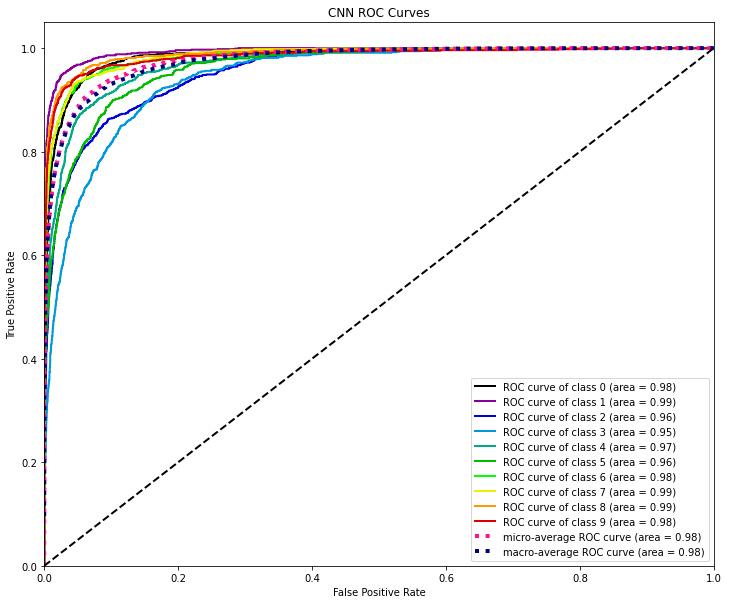

In [36]:
print(cnn_performance)

fig, ax = plt.subplots(figsize=(12,10)) 
ax = sns.heatmap(cnn_cm, annot = True, fmt = 'g', linewidths = .3, cmap = spectral)
ax.set_xticklabels(labels)
ax.set_yticklabels(labels);


skplt.metrics.plot_precision_recall(yTest, cnn_y_probas, figsize = (12, 10), title = 'CNN Precision-Recall Curve');
skplt.metrics.plot_roc(yTest, cnn_y_probas, figsize = (12, 10), title = 'CNN ROC Curves');

limitations: could not gridsearch the desired parameters for cnn cos of time constraints. Also, would've likely benefitted from having more layers [], but this also extended the time too much.